In [28]:
from liblinear.liblinearutil import *
from itertools import combinations_with_replacement
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed


# Dataset

- `mnist.scale` for training
- `mnist.scale.t` for testing


In [2]:
train_data = 'mnist.scale'
test_data = 'mnist.scale.t'

## Read and save data

The training data is saved in the `X_train` list, with each element being a dictionary of features.
example format: {153: 0.0117647, 154: 0.0705882, 155: 0.0705882, ...}

The corresponding label list is saved in `y_train`.

Similarily, the testing data is saved in `X_test` and the corresponding label list is saved in `y_test`.

In [3]:
def read_linear_format(file_path):
    X, y = [], []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts[0] == '2' or parts[0] == '6':
                y.append(int(parts[0]))  
                features = {}
                for item in parts[1:]:
                    index, value = item.split(":")
                    features[int(index)] = float(value)
                X.append(features)
    return X, y

X_train, y_train = read_linear_format(train_data)
X_test, y_test = read_linear_format(test_data)


### Example of the saved data format

- Note: This example has not done selecting out the class 2 and 6 examples.

In [4]:
X = []
with open(train_data, 'r') as f:
    for line in f:
        print("original line:", line)
        parts = line.strip().split()
        print("parts after stripping:", parts)
        features = {}
        for item in parts[1:]:
            index, value = item.split(":")
            features[int(index)] = float(value)
        X.append(features)
        break
        
print("X after first line processed:", X)


original line: 5 153:0.0117647 154:0.0705882 155:0.0705882 156:0.0705882 157:0.494118 158:0.533333 159:0.686275 160:0.101961 161:0.65098 162:1 163:0.968627 164:0.498039 177:0.117647 178:0.141176 179:0.368627 180:0.603922 181:0.666667 182:0.992157 183:0.992157 184:0.992157 185:0.992157 186:0.992157 187:0.882353 188:0.67451 189:0.992157 190:0.94902 191:0.764706 192:0.25098 204:0.192157 205:0.933333 206:0.992157 207:0.992157 208:0.992157 209:0.992157 210:0.992157 211:0.992157 212:0.992157 213:0.992157 214:0.984314 215:0.364706 216:0.321569 217:0.321569 218:0.219608 219:0.152941 232:0.0705882 233:0.858824 234:0.992157 235:0.992157 236:0.992157 237:0.992157 238:0.992157 239:0.776471 240:0.713725 241:0.968627 242:0.945098 261:0.313725 262:0.611765 263:0.419608 264:0.992157 265:0.992157 266:0.803922 267:0.0431373 269:0.168627 270:0.603922 290:0.054902 291:0.00392157 292:0.603922 293:0.992157 294:0.352941 320:0.545098 321:0.992157 322:0.745098 323:0.00784314 348:0.0431373 349:0.745098 350:0.99

In [5]:
y_train[:10]


[2, 6, 2, 6, 2, 2, 6, 6, 6, 6]

## $0/1$ error

In [6]:
def ZeroOneError(predictions, y):
    return sum(p_i != y_i for p_i, y_i in zip(predictions, y)) / len(predictions)

In [7]:
predictions = [2, 2, 6, 2, 6, 2]
y = [2, 2, 2, 2, 2, 2]
res = ZeroOneError(predictions, y)
print(res)

0.3333333333333333


# Regularized logistic regression

## Original Formulation in README.md

As the explanation in the liblinear README file, for <u>L1-regularized logistic regression</u> `(-s 6)`, we solve

\begin{equation} \tag{$\star$}
\min_{\vec{w}} \sum |w_j| + C \sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i))
\end{equation}

### Components of this equation

In this equation, the <u>L1 regularizer</u> is defined as:

\begin{equation*}
\Omega(\vec{w}) = \sum |w_j| = ||\vec{w}||_1
\end{equation*}
> info in Lec14 slide 18

- Note: using L1 regularization encourages sparsity, which means fewer parameters.

And the <u>in-sample error</u> for logistic regression is:

\begin{equation*}
E_{in}(\vec{w}) = \frac{1}{N}\sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i))
\end{equation*}
> in textbook p.91

## Derivation of $C$

Since we knew that:

\begin{equation*}
E_{aug}(\vec{w}) = E_{in}(\vec{w}) + \frac{\lambda}{N} \Omega(\vec{w})
\end{equation*}

We can derive that:

\begin{equation*}
E_{aug}(\vec{w}) = E_{in}(\vec{w}) + \frac{\lambda}{N}\sum |w_j|
\end{equation*}

For minimization:

\begin{equation*}
\begin{split}
\argmin_{\vec{w}} E_{aug}(\vec{w}) 
&= \argmin_{\vec{w}} (E_{in}(\vec{w}) + \frac{\lambda}{N}\sum |w_j|) \\
&= \argmin_{\vec{w}} \frac{N}{\lambda}(\frac{1}{N}\sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i)) + \frac{\lambda}{N}\sum |w_j|) \\
&= \argmin_{\vec{w}} \frac{1}{\lambda}\sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i)) + \sum |w_j|
\end{split}
\end{equation*}

Compare to the original equation marked with ($\star$), we can see that:

\begin{equation*}
C = \frac{1}{\lambda}
\end{equation*}



## Select the best $\lambda^*$

Selecting optimal $\lambda^*$ using the following equation:

\begin{equation*}
\lambda^* = \argmin_{\log_{10}(\lambda) \in \{-2, -1, 0, 1, 2, 3\}} E_{in}(\vec{w}_{\lambda})
\end{equation*}



## get amount of non-zeros

To get the amount of non-zero components in the model, we can use the function `.get_decfun()`:

```python
[W, b] = model_.get_decfun()
```




In [27]:
Eouts = []
non_zero_count_list = []

for experiment in tqdm(range(1126)):

    np.random.seed(experiment)
    min_Ein = np.inf
    opt_log10_lambda = 0
    for log10_lambda in (-2, -1, 0, 1, 2, 3):
        train_pred_res = []
        c = 1 / (10 ** log10_lambda)
        prob = problem(y_train, X_train)
        param = parameter('-s 6 -c ' + str(c))
        model = train(prob, param)

        train_label, _, _ = predict(y_train, X_train, model)
        Ein = ZeroOneError(train_label, y_train)
        if Ein == min_Ein:
            opt_log10_lambda = max(opt_log10_lambda, log10_lambda)      # break tie by choosing the larger lambda
            if opt_log10_lambda == log10_lambda:
                opt_model = model
        elif Ein < min_Ein:
            minEin = Ein
            opt_log10_lambda = log10_lambda
            opt_model = model

    #c_test  = 1 / (10 ** opt_log10_lambda)
    #prob_test = problem(y_test, X_test)
    #param_test = parameter('-s 6 -c ' + str(c_test))
    model_test = opt_model

    test_label, _, _ = predict(y_test, X_test, model_test)
    Eout = ZeroOneError(test_label, y_test)
    
    Eouts.append(Eout)
    
    W = np.array(model_test.get_decfun()[0])
    non_zero_count = np.count_nonzero(W)
    non_zero_count_list.append(non_zero_count)

  0%|          | 0/3 [00:00<?, ?it/s]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32842.768854
#nonzeros/#features = 566/727
Accuracy = 99.2927% (11792/11876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3612.965130
#nonzeros/#features = 509/727
Accuracy = 99.259% (11788/11876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.923259
#nonzeros/#features = 399/727
Accuracy = 99.0485% (11763/11876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objecti

 33%|███▎      | 1/3 [00:11<00:23, 11.77s/it]

Accuracy = 90.201% (1795/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 34403.966670
#nonzeros/#features = 572/727
Accuracy = 99.2337% (11785/11876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3680.140724
#nonzeros/#features = 503/727
Accuracy = 99.2927% (11792/11876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.339795
#nonzeros/#features = 381/727
Accuracy = 99.0232% (11760/11876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD 

 67%|██████▋   | 2/3 [00:36<00:19, 19.33s/it]

Accuracy = 88.8599% (10553/11876) (classification)
Accuracy = 90.3518% (1798/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32911.337095
#nonzeros/#features = 569/727
Accuracy = 99.318% (11795/11876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3642.997113
#nonzeros/#features = 513/727
Accuracy = 99.2674% (11789/11876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.066077
#nonzeros/#features = 389/727
Accuracy = 99.0401% (11762/11876) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3 

100%|██████████| 3/3 [00:48<00:00, 16.13s/it]

Accuracy = 88.7841% (10544/11876) (classification)
Accuracy = 90.3015% (1797/1990) (classification)


In [29]:
non_zero_count_list

[6, 5, 6]

In [31]:
def run_single_experiment(experiment):
    np.random.seed(experiment)
    min_Ein = np.inf
    opt_log10_lambda = 0
    
    for log10_lambda in (-2, -1, 0, 1, 2, 3):
        c = 1 / (10 ** log10_lambda)
        prob = problem(y_train, X_train)
        param = parameter('-s 6 -c ' + str(c))
        model = train(prob, param)

        train_label, _, _ = predict(y_train, X_train, model)
        Ein = ZeroOneError(train_label, y_train)
        if Ein == min_Ein:
            opt_log10_lambda = max(opt_log10_lambda, log10_lambda)
            if opt_log10_lambda == log10_lambda:
                opt_model = model
        elif Ein < min_Ein:
            min_Ein = Ein
            opt_log10_lambda = log10_lambda
            opt_model = model

    test_label, _, _ = predict(y_test, X_test, opt_model)
    Eout = ZeroOneError(test_label, y_test)
    
    W = np.array(opt_model.get_decfun()[0])
    non_zero_count = np.count_nonzero(W)
    
    return Eout, non_zero_count

experiment_amount = 10
results = Parallel(n_jobs=-1)(                                                     # use all cores by setting n_jobs to -1  
    delayed(run_single_experiment)(i) for i in tqdm(range(experiment_amount))
)

Eouts, non_zero_count_list = zip(*results)
Eouts = list(Eouts)
non_zero_count_list = list(non_zero_count_list)

100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32071.751985
#nonzeros/#features = 566/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32071.751985
#nonzeros/#features = 566/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32071.751985
#nonzeros/#features = 566/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32071.751985
#nonzeros/#features = 566/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
ite

In [36]:
non_zero_count_list


[566, 566, 566, 566, 566, 566, 566, 566, 565, 565]

# Plot the histogram

create 2 subplots to separately plot the result of:
1. the distribution of Eout
2. the distribution of the number of non-zero components in the model

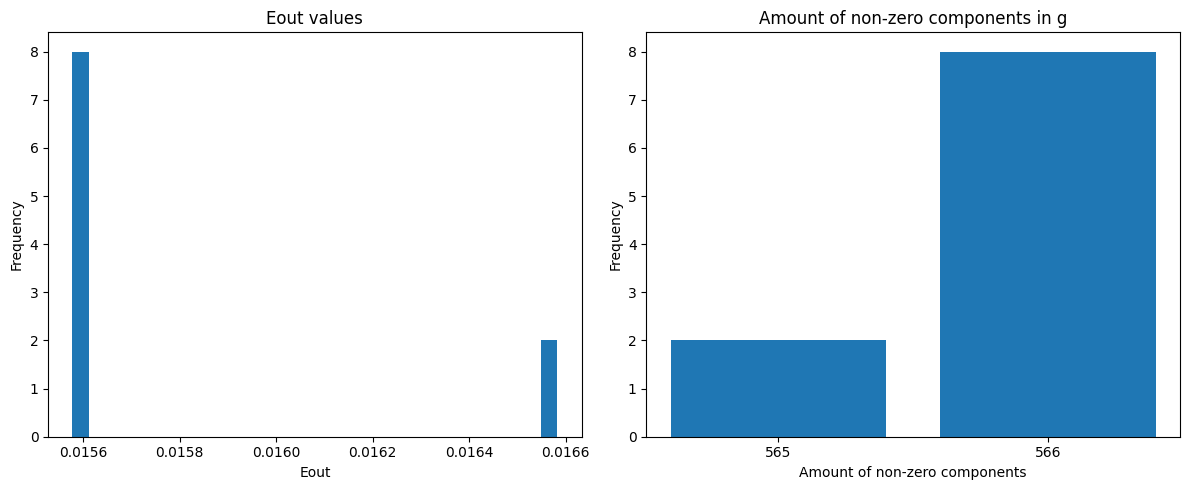

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# aim: First subplot (Eout values)
ax1.hist(Eouts, bins=30)
ax1.set_title('Eout values')
ax1.set_xlabel('Eout')
ax1.set_ylabel('Frequency')

# aim: Second subplot (non-zero components)
min_val = int(min(non_zero_count_list))
max_val = int(max(non_zero_count_list))
integer_bins = np.arange(min_val, max_val + 2) - 0.5  # +2 to include max_val, -0.5 for bin edges

ax2.hist(non_zero_count_list, 
         bins=integer_bins,
         align='mid',
         rwidth=0.8)  

# Force integer ticks
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax2.set_title('Amount of non-zero components in g')
ax2.set_xlabel('Amount of non-zero components')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()